In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from tabulate import tabulate

In [2]:
df = pd.read_csv("clustered_stations.csv")

In [3]:
df.head(10)

,starttime,tripduration,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,age,cluster
0,2018-01-01 13:50:57.434,970,2018-01-01 14:07:08.186,72,40.767272,-73.993929,505,40.749013,-73.988484,31956,Subscriber,1992,1,26,14
1,2018-01-01 15:33:30.182,723,2018-01-01 15:45:33.341,72,40.767272,-73.993929,3255,40.750585,-73.994685,32536,Subscriber,1969,1,49,14
2,2018-01-01 15:39:18.337,496,2018-01-01 15:47:35.172,72,40.767272,-73.993929,525,40.755942,-74.002116,16069,Subscriber,1956,1,62,14
3,2018-01-01 15:40:13.372,306,2018-01-01 15:45:20.191,72,40.767272,-73.993929,447,40.763707,-73.985162,31781,Subscriber,1974,1,44,14
4,2018-01-01 18:14:51.568,306,2018-01-01 18:19:57.642,72,40.767272,-73.993929,3356,40.774667,-73.984706,30319,Subscriber,1992,1,26,14
5,2018-01-01 21:31:54.192,1602,2018-01-01 21:58:36.353,72,40.767272,-73.993929,482,40.739355,-73.999318,30106,Subscriber,1968,1,50,14
6,2018-01-02 07:54:53.646,722,2018-01-02 08:06:55.872,72,40.767272,-73.993929,228,40.754601,-73.971879,32059,Subscriber,1978,1,40,14
7,2018-01-02 08:06:14.331,434,2018-01-02 08:13:28.767,72,40.767272,-73.993929,173,40.760683,-73.984527,30525,Subscriber,1983,1,35,14
8,2018-01-02 08:10:15.255,366,2018-01-02 08:16:21.896,72,40.767272,-73.993929,479,40.760193,-73.991255,27439,Subscriber,1974,1,44,14
9,2018-01-02 08:13:30.896,324,2018-01-02 08:18:55.120,72,40.767272,-73.993929,450,40.762272,-73.987882,30892,Subscriber,1947,1,71,14


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17525144 entries, 0 to 17525143
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   starttime                object 
 1   tripduration             int64  
 2   stoptime                 object 
 3   start_station_id         int64  
 4   start_station_latitude   float64
 5   start_station_longitude  float64
 6   end_station_id           int64  
 7   end_station_latitude     float64
 8   end_station_longitude    float64
 9   bikeid                   int64  
 10  usertype                 object 
 11  birth_year               int64  
 12  gender                   int64  
 13  age                      int64  
 14  cluster                  int64  
dtypes: float64(4), int64(8), object(3)
memory usage: 2.0+ GB


Break the initial DataFrame to cluster DataFrames based on their cluster label

In [5]:
clusters = df['cluster'].unique()
cluster_dfs = {}

for cluster in clusters:
    cluster_df = df[df['cluster'] == cluster].copy()
    cluster_dfs[cluster] = cluster_df


Iterate through the dictionary to find the longest cluster

In [6]:
max_cluster_label = None
max_cluster_length = 0

for cluster_label, cluster_df in cluster_dfs.items():
    cluster_length = len(cluster_df)
    if cluster_length > max_cluster_length:
        max_cluster_length = cluster_length
        max_cluster_label = cluster_label

print(f"Cluster {max_cluster_label} is the longest with {max_cluster_length} rows.")

Cluster 1 is the longest with 1625611 rows.


In [7]:
def create_data_start_and_stop(data: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    data["starttime"] = pd.to_datetime(data["starttime"])
    data["stoptime"] = pd.to_datetime(data["stoptime"])

    data_start = data[["starttime", "tripduration", "start_station_id"]]
    data_stop = data[["stoptime", "tripduration", "end_station_id"]]

    data_start["date"] = data_start["starttime"].dt.date
    data_stop["date"] = data_stop["stoptime"].dt.date   

    # Extract time-related features from 'starttime'
    data_start['hour'] = data_start["starttime"].dt.hour
    data_start['day'] = data_start["starttime"].dt.day
    data_start['month'] = data_start["starttime"].dt.month
    data_start = data_start.drop(columns=["starttime", "tripduration", "start_station_id"])

    data_stop['hour'] = data_stop["stoptime"].dt.hour
    data_stop['day'] = data_stop["stoptime"].dt.day
    data_stop['month'] = data_stop["stoptime"].dt.month
    data_stop = data_stop.drop(columns=["stoptime", "tripduration", "end_station_id"])

    return data_start, data_stop

In [8]:
weather_data = pd.read_csv(r'C:\Users\Ioannis\Desktop\BA\Project\wd\hourly_dataa.csv')

In [9]:
weather_data['date'] = pd.to_datetime(weather_data['date'], format='%Y-%m-%d %H:%M:%S')
#weather_data.drop('date',axis=1, inplace=True)
#weather_data.set_index('date', inplace=True)
weather_data
df1 = weather_data.copy()

In [10]:
from sklearn.preprocessing import StandardScaler

# Assuming your dataset is named 'df'
features = ['temperature_2m', 'precipitation', 'rain', 'snowfall', 'wind_speed_10m']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the selected features
df1[features] = scaler.fit_transform(df1[features])

# Now, 'temperature_2m', 'precipitation', 'rain', 'snowfall', 'wind_speed_10m' are standardized


In [11]:
weather_data

,date,temperature_2m,precipitation,rain,snowfall,wind_speed_10m,relative_humidity_2m,apparent_temperature,wind_gusts_10m,soil_temperature_0_to_7cm,soil_moisture_0_to_7cm,snow_depth
0,2018-01-01 05:00:00,9.608500,0.2,0.2,0.0,20.945070,5.590458,0.0,79.078636,41.399998,7.8585,20.945070
1,2018-01-01 06:00:00,9.258500,0.1,0.1,0.0,21.868332,5.027298,0.0,79.026760,37.079998,7.6585,21.868332
2,2018-01-01 07:00:00,8.808500,0.0,0.0,0.0,22.972400,4.098280,0.0,73.386070,39.600000,7.4585,22.972400
3,2018-01-01 08:00:00,8.008500,0.0,0.0,0.0,25.199997,2.933147,0.0,76.395220,42.480000,7.1085,25.199997
4,2018-01-01 09:00:00,8.158501,0.0,0.0,0.0,27.162708,2.631478,0.0,71.230194,46.440000,7.1085,27.162708
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2019-01-01 00:00:00,7.408500,0.0,0.0,0.0,18.861387,3.903855,0.0,97.634850,36.000000,6.9585,18.861387
8756,2019-01-01 01:00:00,7.508500,0.0,0.0,0.0,21.659918,3.559998,0.0,95.978990,36.719997,6.8085,21.659918
8757,2019-01-01 02:00:00,7.258500,0.0,0.0,0.0,23.688984,2.920302,0.0,94.986580,40.320000,6.6585,23.688984
8758,2019-01-01 03:00:00,7.208500,0.0,0.0,0.0,26.867676,2.292699,0.0,92.083260,46.079998,6.5585,26.867676


In [12]:
#weather_data = df1

In [13]:
def wet_dat(data: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    data["date"] = pd.to_datetime(data["date"], errors='coerce')
    
    data_start = data[["date","temperature_2m", "apparent_temperature", "snow_depth","precipitation", "rain", "snowfall", "wind_speed_10m","relative_humidity_2m", "wind_gusts_10m", "soil_temperature_0_to_7cm", "soil_moisture_0_to_7cm"]]
    
    data_start['date'] = pd.to_datetime(data_start['date'])
    #data_start['hour'] = data_start['date'].dt.hour
    data_start['hour'] = data_start['date'].apply(lambda x: x.hour)
    data_start['day'] = data_start['date'].apply(lambda x: x.day)
    data_start['month'] = data_start['date'].apply(lambda x: x.month)
    data_start["date"] = data_start["date"].dt.date
    
    # Extract time-related features from 'starttime'
    #data_start['hour'] = data_start["date"].dt.hour
    # data_start['day'] = data_start["date"].dt.day
    # data_start['month'] = data_start["date"].dt.month

    return data_start

In [16]:
d = wet_dat(weather_data)
d[:1000]

,date,temperature_2m,apparent_temperature,snow_depth,precipitation,rain,snowfall,wind_speed_10m,relative_humidity_2m,wind_gusts_10m,soil_temperature_0_to_7cm,soil_moisture_0_to_7cm,hour,day,month
0,2018-01-01,9.608500,0.00,20.945070,0.2,0.2,0.0,20.945070,5.590458,79.078636,41.399998,7.8585,5,1,1
1,2018-01-01,9.258500,0.00,21.868332,0.1,0.1,0.0,21.868332,5.027298,79.026760,37.079998,7.6585,6,1,1
2,2018-01-01,8.808500,0.00,22.972400,0.0,0.0,0.0,22.972400,4.098280,73.386070,39.600000,7.4585,7,1,1
3,2018-01-01,8.008500,0.00,25.199997,0.0,0.0,0.0,25.199997,2.933147,76.395220,42.480000,7.1085,8,1,1
4,2018-01-01,8.158501,0.00,27.162708,0.0,0.0,0.0,27.162708,2.631478,71.230194,46.440000,7.1085,9,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2018-02-11,1.708500,0.01,17.399586,0.0,0.0,0.0,17.399586,-2.898066,90.748886,33.120000,0.4585,16,11,2
996,2018-02-11,1.508500,0.01,15.175612,0.0,0.0,0.0,15.175612,-2.812892,90.406395,29.160000,0.4585,17,11,2
997,2018-02-11,0.958500,0.01,13.779114,0.0,0.0,0.0,13.779114,-3.220650,91.356470,25.560000,0.4085,18,11,2
998,2018-02-11,0.858500,0.01,12.904882,0.0,0.0,0.0,12.904882,-3.200732,91.682526,23.039999,0.4085,19,11,2


In [17]:


#in the rain column put 1 if it rained and 0 if it didn't
d['rain'] = d['rain'].apply(lambda x: 1 if x > 0.5 else 0)



In [18]:
d['rain'].describe()

count    8760.000000
mean        0.018037
std         0.133091
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: rain, dtype: float64

In [19]:
def create_pickups_df(data, target_name):
    # Group the data by 'hour', 'day', and 'month', and count the rows for each unique combination
    pickups = data.groupby(['date','hour', 'day', 'month']).size().reset_index(name=target_name)
    pickups = pickups.set_index("date")

    # Create a DataFrame with all possible combinations of 'hour,' 'day,' 'month' for 24 hours
    dates = pickups.index.unique()
    hours = range(24)

    date_hour_combinations = pd.DataFrame(
        [(date, hour) for date in dates for hour in hours ],
        columns=['date', 'hour']
    )

    date_hour_combinations['date'] = pd.to_datetime(date_hour_combinations['date'])
    date_hour_combinations['month'] = date_hour_combinations['date'].dt.month
    date_hour_combinations['day'] = date_hour_combinations['date'].dt.day

    # Set 'date' as the index
    date_hour_combinations['date'] = date_hour_combinations['date'].dt.date
    date_hour_combinations.set_index('date', inplace=True)

    combined_data = pd.merge(date_hour_combinations, pickups, on=['date', 'hour', 'day', 'month'], how='left')

    # Fill missing 'pickups' values with 0
    combined_data[target_name].fillna(0, inplace=True)

    return combined_data


In [20]:
data = cluster_dfs[max_cluster_label]
#print(data.head())
data_start, data_stop = create_data_start_and_stop(data)
combined_pickup_data = create_pickups_df(data_start, 'pickups')
combined_dropoff_data = create_pickups_df(data_stop, 'dropoffs')



C:\Users\Ioannis\AppData\Local\Temp\ipykernel_19512\2978950130.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_start["date"] = data_start["starttime"].dt.date
C:\Users\Ioannis\AppData\Local\Temp\ipykernel_19512\2978950130.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_stop["date"] = data_stop["stoptime"].dt.date
C:\Users\Ioannis\AppData\Local\Temp\ipykernel_19512\2978950130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [214]:
#merge weather data with pdata
combined_datap = pd.merge(combined_pickup_data, d, on=['date', 'hour', 'day', 'month'], how='left')
combined_datad = pd.merge(combined_dropoff_data, d, on=['date', 'hour', 'day', 'month'], how='left')



In [215]:
combined_datad.head(10)

,date,hour,month,day,dropoffs,temperature_2m,apparent_temperature,snow_depth,precipitation,rain,snowfall,wind_speed_10m,relative_humidity_2m,wind_gusts_10m,soil_temperature_0_to_7cm,soil_moisture_0_to_7cm
0,2018-01-01,0,1,1,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,1,1,1,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,2,1,1,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,3,1,1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,4,1,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018-01-01,5,1,1,1.0,9.608500,0.0,20.945070,0.2,0.0,0.0,20.945070,5.590458,79.078636,41.399998,7.8585
6,2018-01-01,6,1,1,2.0,9.258500,0.0,21.868332,0.1,0.0,0.0,21.868332,5.027298,79.026760,37.079998,7.6585
7,2018-01-01,7,1,1,7.0,8.808500,0.0,22.972400,0.0,0.0,0.0,22.972400,4.098280,73.386070,39.600000,7.4585
8,2018-01-01,8,1,1,10.0,8.008500,0.0,25.199997,0.0,0.0,0.0,25.199997,2.933147,76.395220,42.480000,7.1085
9,2018-01-01,9,1,1,11.0,8.158501,0.0,27.162708,0.0,0.0,0.0,27.162708,2.631478,71.230194,46.440000,7.1085


In [226]:
#remove all the rows with NaN values
combined_datap = combined_datap.dropna()
combined_datad = combined_datad.dropna()

In [227]:
#add a column isweekend
combined_datap['isweekend'] = combined_datap['date'].apply(lambda x: 1 if x.weekday() > 4 else 0)
combined_datad['isweekend'] = combined_datad['date'].apply(lambda x: 1 if x.weekday() > 4 else 0)

In [228]:
hol = pd.read_csv(r'C:\Users\Ioannis\Desktop\BA\Project\pub_holidays.csv')

In [229]:
hol

,Date,Day,Holiday
0,1 Jan,Mon,New Year's Day
1,15 Jan,Mon,Martin Luther King Jr. Birthday
2,12 Feb,Mon,Lincoln's Birthday
3,19 Feb,Mon,President's Day
4,28 May,Mon,Memorial Day
5,4 Jul,Wed,Independence Day
6,3 Sep,Mon,Labor Day
7,8 Oct,Mon,Columbus Day
8,6 Nov,Tue,General Election Day
9,11 Nov,Sun,Veterans Day


In [230]:
#i want my date column to be datetime
hol['Date'] = pd.to_datetime(hol['Date'] + ' 2018', format='%d %b %Y')

In [231]:
combined_datad['date'] = pd.to_datetime(combined_datad['date']) 
combined_datap['date'] = pd.to_datetime(combined_datap['date'])

In [232]:
#creatre a column isholiday
combined_datap['isholiday'] = combined_datap['date'].apply(lambda x: 1 if x in hol['Date'].values else 0)
combined_datad['isholiday'] = combined_datad['date'].apply(lambda x: 1 if x in hol['Date'].values else 0)

c:\Users\Ioannis\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1600x800 with 0 Axes>

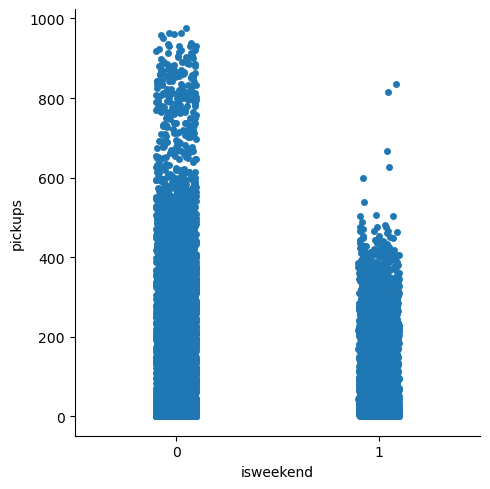

In [233]:

plt.figure(figsize=(16,8))
sns.catplot(data=combined_datap, x='isweekend', y='pickups')

c:\Users\Ioannis\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1600x800 with 0 Axes>

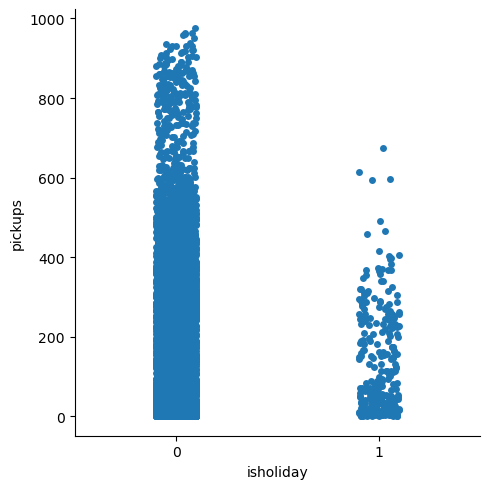

In [234]:

plt.figure(figsize=(16,8))
sns.catplot(data=combined_datap, x='isholiday', y='pickups')

In [208]:
#i want the avg trip count on weekend and weekdays
weekend = combined_datap[combined_datap['isweekend'] == 1]
weekday = combined_datap[combined_datap['isweekend'] == 0]


In [209]:

weekend.set_index('date', inplace=True)
weekend.loc[:, 'pickups'] = weekend['pickups'].sum()
average_pickups_weekend = weekend['pickups'][0] / len(weekend)
print(average_pickups_weekend)


134.10817307692307


In [210]:

weekday.set_index('date', inplace=True)
weekday.loc[:, 'pickups'] = weekday['pickups'].sum()
average_pickups_weekday = weekday['pickups'][0] / len(weekday)
print(average_pickups_weekday)


206.2364594983224


The following code creates a df with pickups for every hour. Because some hours in the dataframe could be non existent (for example no data from 12.00 to 12.59 at 2018-01-09) we fill them with 0 pickups

In [191]:

   
def plot_temp_pickups(data: pd.DataFrame):
    data['datetime'] = pd.to_datetime(data['date'])
    data.set_index('datetime', inplace=True)

    #sum all the pickups per day
    data['pickups'] = data['pickups'].resample('D').sum()

    data.reset_index(inplace=True)
    #data.drop('datetime',axis=1, inplace=True)
    fig, ax1 = plt.subplots(figsize=(20,10))
    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('pickups', color=color)
    ax1.plot(data['date'], data['pickups'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title('Temperature and Pickups')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('temperature', color=color)  # we already handled the x-label with ax1
    ax2.plot(data['date'], data['temperature_2m'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show() 

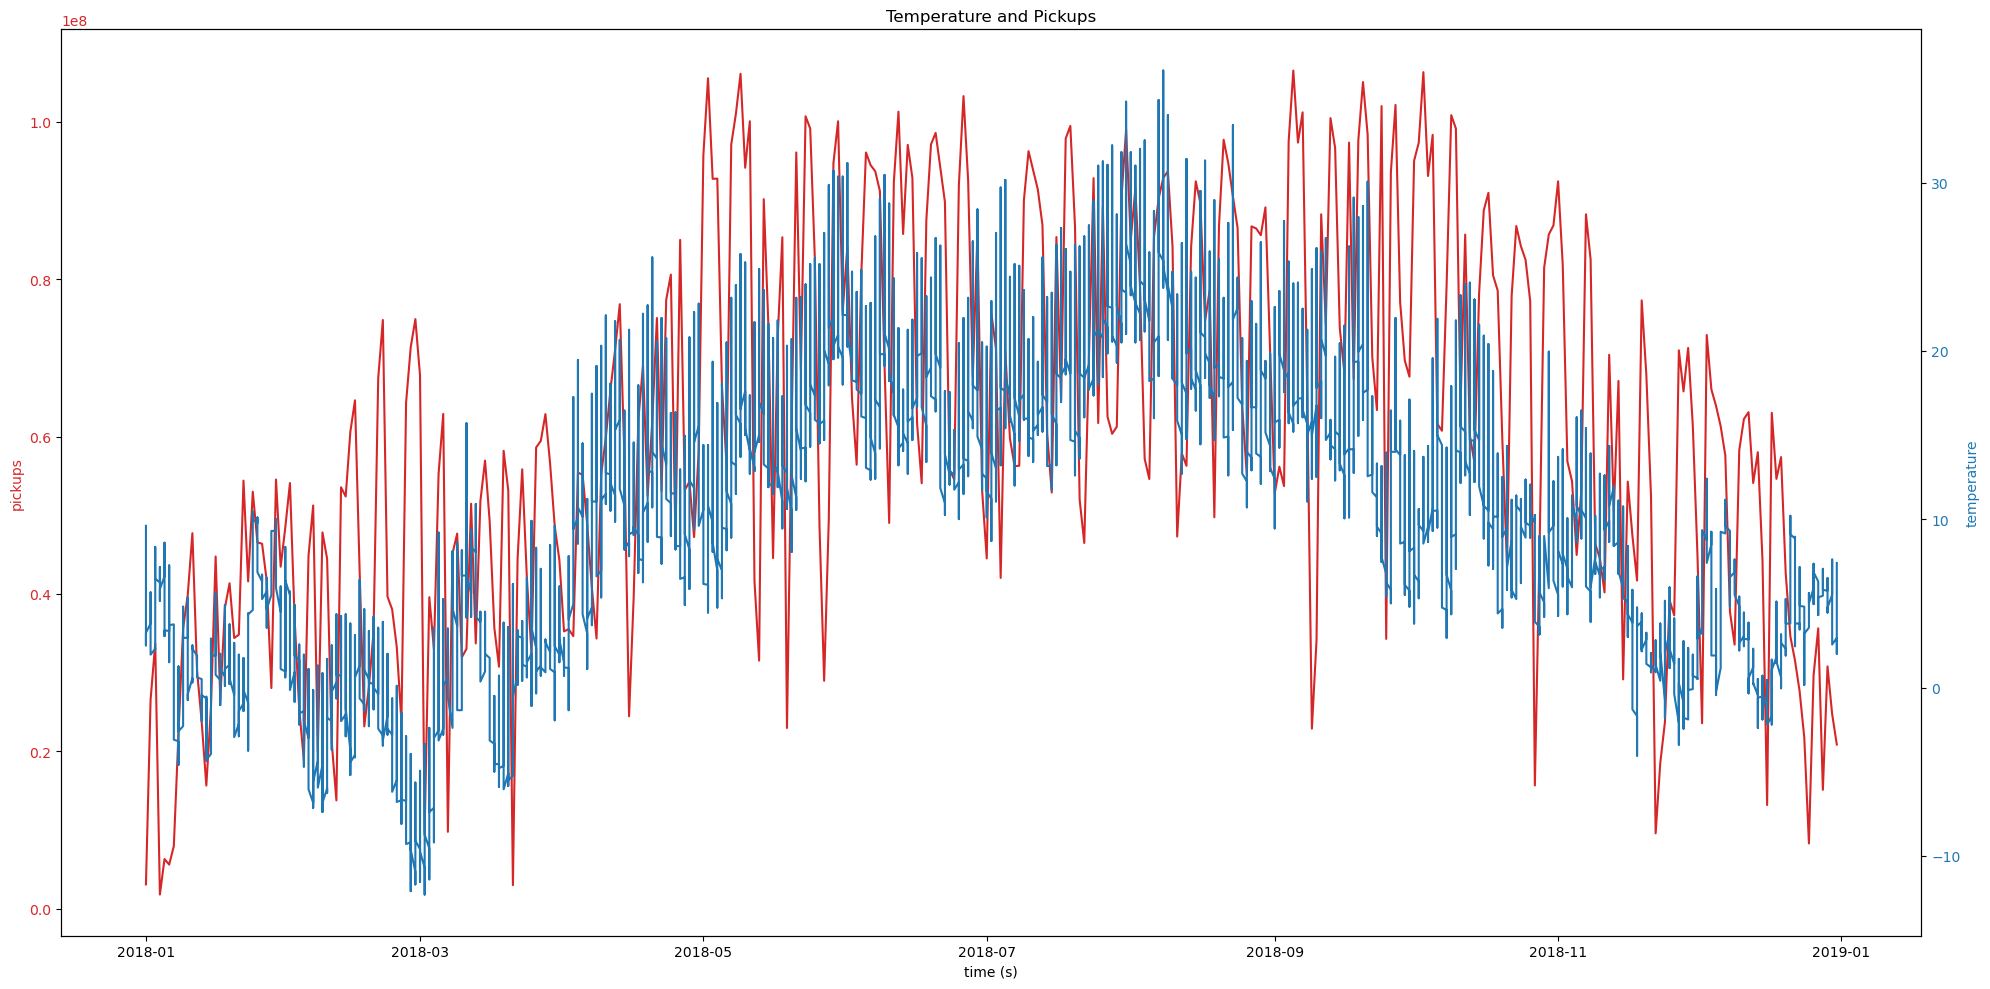

In [192]:
plot_temp_pickups(combined_datap)

The following function takes as argument a DataFrame, a list of training months and test months and a target name ('pickups' or 'dropoffs') and returns the Train and Test data ready to be used in the training loop.

In [195]:
def prediction_preparation(df, train_months, test_months, target_name):
    lag_columns = [c for c in df.columns if c.startswith("lag")]
    X = df[['day','month','hour', "temperature_2m","soil_moisture_0_to_7cm","isweekend",'isholiday']+ lag_columns]
    #X = df[['day','month','hour',"temperature_2m", "precipitation", "rain","snowfall", "wind_speed_10m"]+ lag_columns]
    y = df[['day','month','hour',target_name]]

    scaler = StandardScaler()
    
    X.loc[:, lag_columns] = scaler.fit_transform(X[lag_columns])

    X_train = X[X['month'].isin(train_months)]
    X_test = X[X['month'].isin(test_months)]
    y_train = y[y['month'].isin(train_months)]
    y_test = y[y['month'].isin(test_months)]

    return X_train, X_test, y_train, y_test

The following function acts as training loop. We give as args:
- the model, 
- the train and test data,
- the target name ("pickups" or "dropoffs") 

It trains the given model, evaluates it using Cross Validation method and finally tests it in not seen data (The test data).

In [211]:
pickups_lagged = buildLaggedFeatures(s=combined_datap, columns= ['pickups'], lag = 4, dropna=False)
pickups_lagged = pickups_lagged.apply(lambda row: row.fillna(0))

dropoffs_lagged = buildLaggedFeatures(s=combined_datad, columns= ['dropoffs'], lag = 4, dropna=False)
dropoffs_lagged = dropoffs_lagged.apply(lambda row: row.fillna(0))

train_months = [1,2,3,4,5,6,7,8,9,10]
test_months =  [11,12]

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
xgb_model = XGBRegressor(subsample= 0.8, n_estimators = 300, min_child_weight = 3, max_depth = 4, learning_rate = 0.1, gamma = 1, colsample_bytree = 0.9)




from lightgbm import LGBMRegressor
lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=42)

from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=42)

lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
model_list = [lr_model, rf_model,xgb_model]

table = []
titles = ["Model", "Target", "Final Test Score", "Final Test RMSE", "Average CV score", "Average CV RMSE"]
table.append(titles)

prediction_dfs = []

for model in model_list:
    prediction_df = combined_pickup_data.drop(columns=['pickups'])
    prediction_df = prediction_df[prediction_df['month'].isin(test_months)] 
    for df in [pickups_lagged, dropoffs_lagged]:
        target_name = 'pickups' if 'pickups' in df.columns else 'dropoffs'
        X_train, X_test, y_train, y_test = prediction_preparation(df, train_months, test_months, target_name)
        # -------- Task 2 ------- #
        CV_score, CV_RMSE, test_score, test_RMSE, preds = training_loop(model, X_train, y_train, X_test, y_test, target_name)
        row = [model, target_name, test_score, test_RMSE, CV_score, CV_RMSE]
        table.append(row)
        # -------- Task 3 ------- #
        prediction_df[target_name] = preds
    prediction_dfs.append(prediction_df)


--------------------------------------
Month : 1 

Train Score:  0.8512987672494162
Train RMSE :  39.94849707978461
Test Score:  0.8316534197733972
Test RMSE :  54.27904408580288
--------------------------------------
Month : 2 

Train Score:  0.8494802909855546
Train RMSE :  46.28809437308936
Test Score:  0.8281041061701797
Test RMSE :  54.52586365084292
--------------------------------------
Month : 3 

Train Score:  0.8484741027658923
Train RMSE :  48.25333249925397
Test Score:  0.835625461327763
Test RMSE :  64.42427698303617
--------------------------------------
Month : 4 

Train Score:  0.8494973527673546
Train RMSE :  52.40716774682821
Test Score:  0.8183686518179276
Test RMSE :  92.80402140489505
--------------------------------------
Month : 5 

Train Score:  0.848683709378857
Train RMSE :  62.52100174358987
Test Score:  0.8204620488814797
Test RMSE :  90.23015453847532
--------------------------------------
Month : 6 

Train Score:  0.8479094450702752
Train RMSE :  67.819938

In [212]:
print(tabulate(table, headers='firstrow',colalign=("left",), floatfmt=".4f"))

Model                                                                         Target      Final Test Score    Final Test RMSE    Average CV score    Average CV RMSE
----------------------------------------------------------------------------  --------  ------------------  -----------------  ------------------  -----------------
LinearRegression()                                                            pickups               0.8460            56.3680              0.8200            79.0000
LinearRegression()                                                            dropoffs              0.8419            56.8100              0.8286            76.0000
RandomForestRegressor(random_state=42)                                        pickups               0.9239            39.6258              0.9202            50.0000
RandomForestRegressor(random_state=42)                                        dropoffs              0.9414            34.6056              0.9318            46.0000
XGBRegress

In [133]:
#combined_datap.set_index('date', inplace=True)
#keep only the 11 and 12 month
combined_datap = combined_datap[combined_datap['month'].isin(test_months)]


In [136]:
combined_datap

,hour,month,day,pickups,temperature_2m,apparent_temperature,snow_depth,precipitation,rain,snowfall,wind_speed_10m,relative_humidity_2m,wind_gusts_10m,soil_temperature_0_to_7cm,soil_moisture_0_to_7cm,isweekend,isholiday
date,,,,,,,,,,,,,,,,,
2018-11-01,0,11,1,54.0,5.5085,0.0,8.759178,0.0,0.0,0.0,8.759178,2.665012,85.432770,17.640000,5.9585,0,0
2018-11-01,1,11,1,22.0,4.9585,0.0,9.531505,0.0,0.0,0.0,9.531505,1.992825,88.448456,15.840000,6.0085,0,0
2018-11-01,2,11,1,13.0,4.9585,0.0,10.182337,0.0,0.0,0.0,10.182337,1.935933,89.705925,16.919998,6.0085,0,0
2018-11-01,3,11,1,7.0,4.5585,0.0,7.952660,0.0,0.0,0.0,7.952660,1.841949,91.595810,16.560000,6.0085,0,0
2018-11-01,4,11,1,5.0,4.2585,0.0,7.968939,0.0,0.0,0.0,7.968939,1.520564,92.880300,12.599999,5.8585,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31,19,12,31,19.0,6.6085,0.0,13.237039,0.0,0.0,0.0,13.237039,3.580719,93.009200,22.319998,5.6085,0,0
2018-12-31,20,12,31,12.0,6.8085,0.0,14.241629,0.0,0.0,0.0,14.241629,3.745191,94.968930,23.400000,5.7085,0,0
2018-12-31,21,12,31,4.0,7.0585,0.0,15.725037,0.0,0.0,0.0,15.725037,3.881684,96.295470,26.280000,5.8085,0,0


In [142]:
#plot the compined_datap['pickups'] and the date
def plot_pickups(data: pd.DataFrame):
    fig, ax1 = plt.subplots(figsize=(20,10))
    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('daily_cumulative_departures', color=color)
    ax1.plot(data.index, data['daily_cumulative_departures'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title('Pickups')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


In [152]:
#merge the compined_datap with combined_datad on date hour and day
test = pd.merge(combined_datap, combined_datad, on=['date', 'hour', 'day', 'month'], how='left')

In [153]:
#sustruct the dropoffs from the pickups
test['test'] = test['pickups'] - test['dropoffs']


In [161]:
test.set_index('date', inplace=True)
test['last'] = test.groupby(test.index)[['test']].last()   

In [162]:
test['last'] 

date
2018-11-01   -2.0
2018-11-01   -2.0
2018-11-01   -2.0
2018-11-01   -2.0
2018-11-01   -2.0
             ... 
2018-12-31    0.0
2018-12-31    0.0
2018-12-31    0.0
2018-12-31    0.0
2018-12-31    0.0
Name: last, Length: 1464, dtype: float64

----------------------- M O D E L 1 --------------------------------


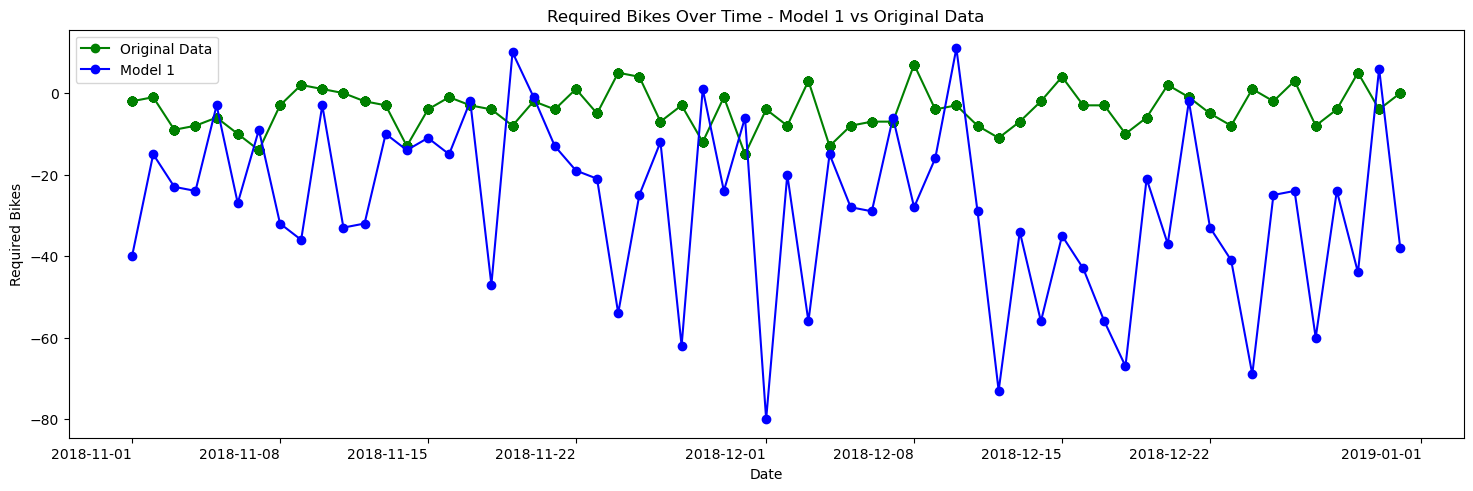

----------------------- M O D E L 2 --------------------------------


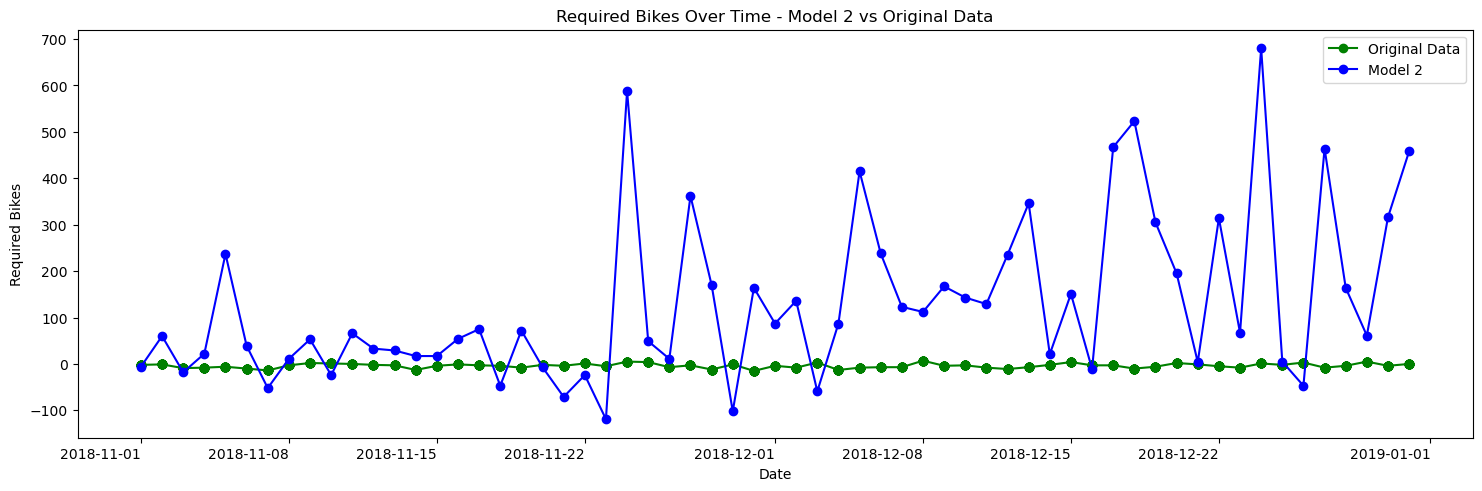

----------------------- M O D E L 3 --------------------------------


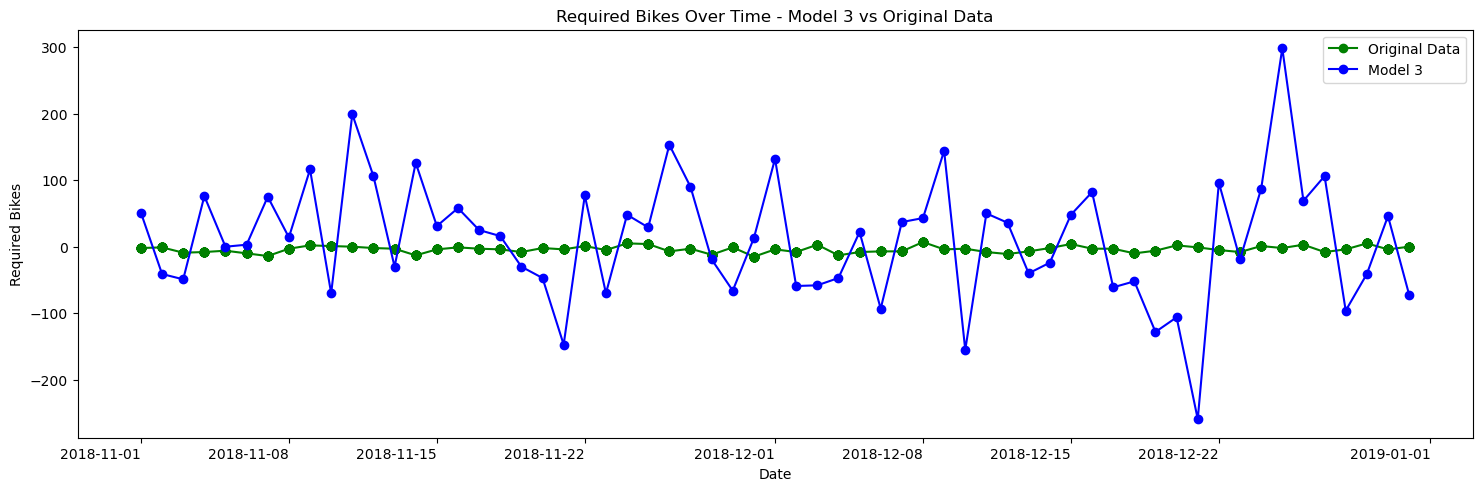

In [163]:
import matplotlib.pyplot as plt

# Assuming y_test is your DataFrame with the original data
# Replace 'required_bikes_original' and 'dropoffs' with your actual column names in y_test
#combined_datap['required_bikes_original'] = combined_datap['dropoffs']

i = 0
for prediction_df in prediction_dfs:
    i += 1
    print(f"----------------------- M O D E L {i} --------------------------------")
    prediction_df['pickups'] = prediction_df['pickups'].astype(int)
    prediction_df['dropoffs'] = prediction_df['dropoffs'].astype(int)
    # Calculate daily cumulative arrivals and departures
    prediction_df['daily_cumulative_arrivals'] = prediction_df.groupby('day')['dropoffs'].transform('cumsum')
    prediction_df['daily_cumulative_departures'] = prediction_df.groupby('day')['pickups'].transform('cumsum')

    daily_cumulative = prediction_df.groupby(prediction_df.index)[['daily_cumulative_arrivals', 'daily_cumulative_departures']].last()
    daily_cumulative['required_bikes'] = daily_cumulative['daily_cumulative_departures'] - daily_cumulative['daily_cumulative_arrivals']
    
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(18, 6))
    
    # Plot the required bikes from the original data
    test['last'].plot(marker='o', linestyle='-', color='g', label='Original Data', ax=ax)
    
    # Plot the required bikes from the prediction data
    daily_cumulative['required_bikes'].plot(marker='o', linestyle='-', color='b', label=f'Model {i}', ax=ax)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Required Bikes')
    ax.set_title(f'Required Bikes Over Time - Model {i} vs Original Data')
    ax.legend()
    plt.show()



----------------------- M O D E L 1 --------------------------------
For date: 2018-11-01 Cluster: 1 needs -40 bikes.
For date: 2018-11-02 Cluster: 1 needs -15 bikes.
For date: 2018-11-03 Cluster: 1 needs -23 bikes.
For date: 2018-11-04 Cluster: 1 needs -24 bikes.
For date: 2018-11-05 Cluster: 1 needs -3 bikes.
For date: 2018-11-06 Cluster: 1 needs -27 bikes.
For date: 2018-11-07 Cluster: 1 needs -9 bikes.
For date: 2018-11-08 Cluster: 1 needs -32 bikes.
For date: 2018-11-09 Cluster: 1 needs -36 bikes.
For date: 2018-11-10 Cluster: 1 needs -3 bikes.
For date: 2018-11-11 Cluster: 1 needs -33 bikes.
For date: 2018-11-12 Cluster: 1 needs -32 bikes.
For date: 2018-11-13 Cluster: 1 needs -10 bikes.
For date: 2018-11-14 Cluster: 1 needs -14 bikes.
For date: 2018-11-15 Cluster: 1 needs -11 bikes.
For date: 2018-11-16 Cluster: 1 needs -15 bikes.
For date: 2018-11-17 Cluster: 1 needs -2 bikes.
For date: 2018-11-18 Cluster: 1 needs -47 bikes.
For date: 2018-11-19 Cluster: 1 needs 10 bikes.
For d

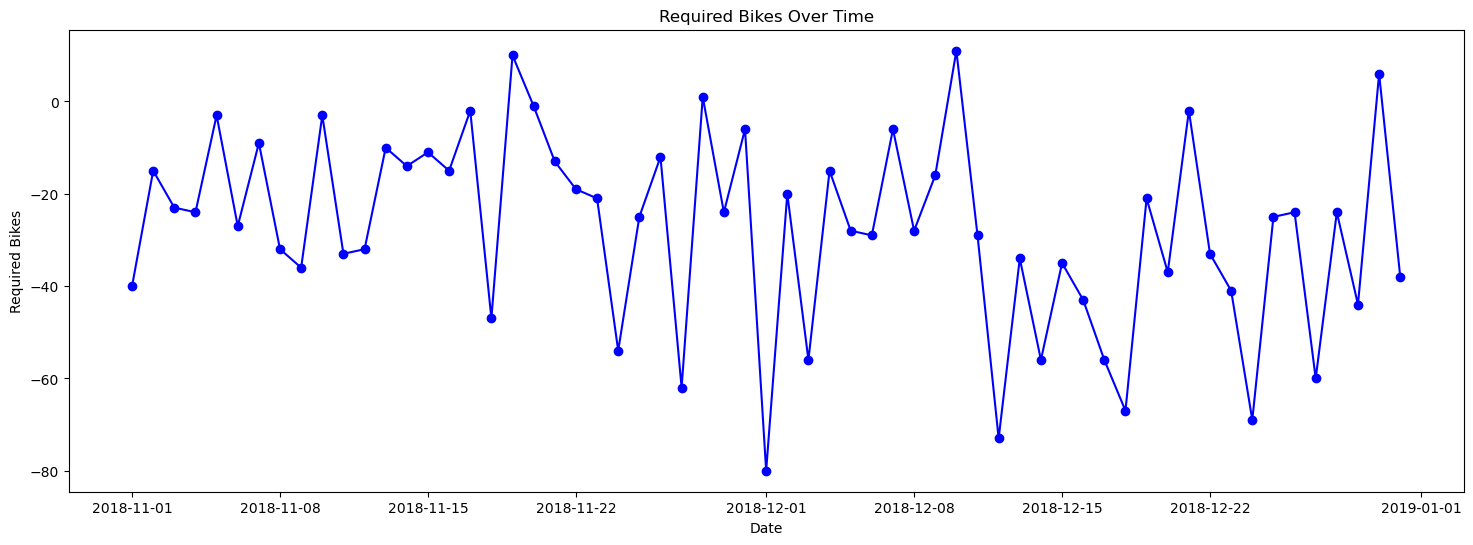

----------------------- M O D E L 2 --------------------------------
For date: 2018-11-01 Cluster: 1 needs -6 bikes.
For date: 2018-11-02 Cluster: 1 needs 60 bikes.
For date: 2018-11-03 Cluster: 1 needs -18 bikes.
For date: 2018-11-04 Cluster: 1 needs 22 bikes.
For date: 2018-11-05 Cluster: 1 needs 237 bikes.
For date: 2018-11-06 Cluster: 1 needs 39 bikes.
For date: 2018-11-07 Cluster: 1 needs -52 bikes.
For date: 2018-11-08 Cluster: 1 needs 11 bikes.
For date: 2018-11-09 Cluster: 1 needs 53 bikes.
For date: 2018-11-10 Cluster: 1 needs -24 bikes.
For date: 2018-11-11 Cluster: 1 needs 66 bikes.
For date: 2018-11-12 Cluster: 1 needs 33 bikes.
For date: 2018-11-13 Cluster: 1 needs 29 bikes.
For date: 2018-11-14 Cluster: 1 needs 17 bikes.
For date: 2018-11-15 Cluster: 1 needs 17 bikes.
For date: 2018-11-16 Cluster: 1 needs 54 bikes.
For date: 2018-11-17 Cluster: 1 needs 75 bikes.
For date: 2018-11-18 Cluster: 1 needs -47 bikes.
For date: 2018-11-19 Cluster: 1 needs 72 bikes.
For date: 2018

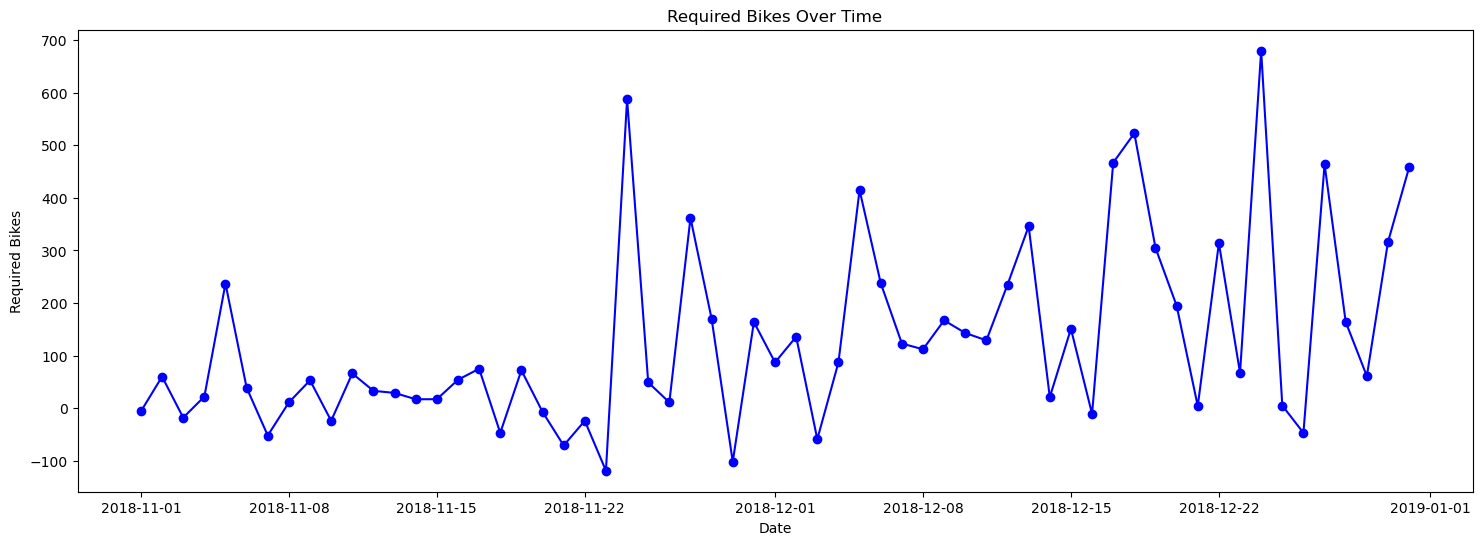

----------------------- M O D E L 3 --------------------------------
For date: 2018-11-01 Cluster: 1 needs 51 bikes.
For date: 2018-11-02 Cluster: 1 needs -41 bikes.
For date: 2018-11-03 Cluster: 1 needs -49 bikes.
For date: 2018-11-04 Cluster: 1 needs 76 bikes.
For date: 2018-11-05 Cluster: 1 needs 0 bikes.
For date: 2018-11-06 Cluster: 1 needs 3 bikes.
For date: 2018-11-07 Cluster: 1 needs 75 bikes.
For date: 2018-11-08 Cluster: 1 needs 14 bikes.
For date: 2018-11-09 Cluster: 1 needs 116 bikes.
For date: 2018-11-10 Cluster: 1 needs -70 bikes.
For date: 2018-11-11 Cluster: 1 needs 199 bikes.
For date: 2018-11-12 Cluster: 1 needs 106 bikes.
For date: 2018-11-13 Cluster: 1 needs -30 bikes.
For date: 2018-11-14 Cluster: 1 needs 126 bikes.
For date: 2018-11-15 Cluster: 1 needs 31 bikes.
For date: 2018-11-16 Cluster: 1 needs 58 bikes.
For date: 2018-11-17 Cluster: 1 needs 25 bikes.
For date: 2018-11-18 Cluster: 1 needs 16 bikes.
For date: 2018-11-19 Cluster: 1 needs -30 bikes.
For date: 20

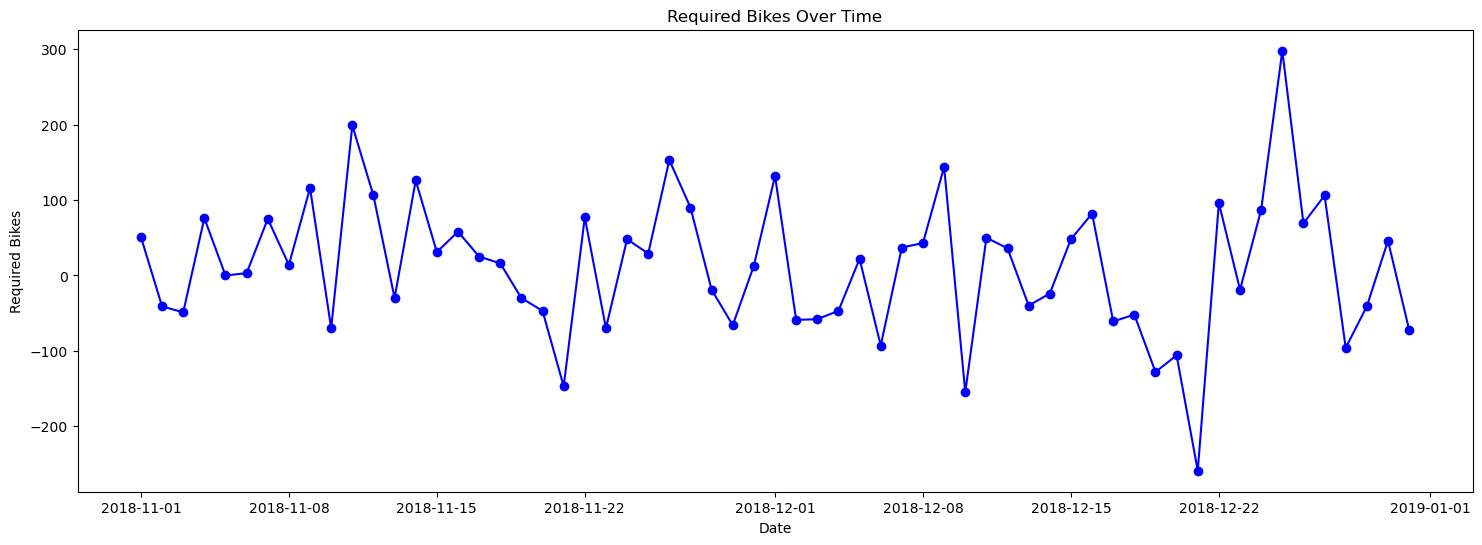

In [135]:
i = 0
for prediction_df in prediction_dfs:
    i = i+1
    print(f"----------------------- M O D E L {i} --------------------------------")
    prediction_df['pickups'] = prediction_df['pickups'].astype(int)
    prediction_df['dropoffs'] = prediction_df['dropoffs'].astype(int)
    # Calculate daily cumulative arrivals and departures
    prediction_df['daily_cumulative_arrivals'] = prediction_df.groupby('day')['dropoffs'].transform('cumsum')
    prediction_df['daily_cumulative_departures'] = prediction_df.groupby('day')['pickups'].transform('cumsum')

    daily_cumulative = prediction_df.groupby(prediction_df.index)[['daily_cumulative_arrivals', 'daily_cumulative_departures']].last()
    daily_cumulative['required_bikes'] = daily_cumulative['daily_cumulative_departures'] - daily_cumulative['daily_cumulative_arrivals']
    
    for date in daily_cumulative.index:
        print(f"For date: {date} Cluster: {max_cluster_label} needs {daily_cumulative.loc[date, 'required_bikes']} bikes.")
    
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(18, 6))
    daily_cumulative['required_bikes'].plot(marker='o', linestyle='-', color='b', ax=ax)
    ax.set_xlabel('Date')
    ax.set_ylabel('Required Bikes')
    ax.set_title('Required Bikes Over Time')
    plt.show()
    